# Bank Customer Churn Prediction

## 1. Load Libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV 

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

## 2. Data Collection

In [2]:
df = pd.read_csv('Bank_Customer_Churn_Engineered.csv')
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,BalanceSalaryRatio,TenureByAge,CreditScoreByAge
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.046512,14.395349
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744670,0.023810,14.476190
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401362,0.186047,11.674419
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025000,17.475000
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587035,0.045455,19.318182


In [3]:
df.shape

(10000, 14)

In [4]:
print(df['churn'].value_counts())

churn
0    7963
1    2037
Name: count, dtype: int64


## 3. Preparing Features (X) and Target (y):

In [5]:
# Separate features (X) and target (y): Also dropping irrelevant features
X = df.drop(columns=['churn'], axis=1)
y = df['churn']

In [6]:
X.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,BalanceSalaryRatio,TenureByAge,CreditScoreByAge
0,619,France,Female,42,2,0.00,1,1,1,101348.88,0.000000,0.046512,14.395349
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0.744670,0.023810,14.476190
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1.401362,0.186047,11.674419
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0.000000,0.025000,17.475000
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,1.587035,0.045455,19.318182


In [7]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: churn, dtype: int64

## 4. Splitting Data

##### Train-Test Data Split:

In [8]:
# Split the Original Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 5. Transformation Pipeline

In [9]:

# 1. Pipeline for Skewed/Outlier-prone Numerical Features (Age, CreditScore, Balance)
# PowerTransformer (Yeo-Johnson) handles skewness; RobustScaler handles outliers
num_transformer = Pipeline(steps=[
    ('skewed', PowerTransformer(method='yeo-johnson')),
    ('outliers', RobustScaler()),
    ("Scaler", StandardScaler())
])

# 2. Pipeline for Categorical & Discrete Features (Geography, Gender, IsActiveMember, etc.)
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# 3. Combine Preprocessing
# We drop 'RowNumber', 'CustomerId', and 'Surname' as identified in EDA
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, ['age', 'credit_score', 'balance', 'estimated_salary', 'tenure',
                                  'BalanceSalaryRatio',	'TenureByAge', 'CreditScoreByAge']),
        ('cat', cat_transformer, ['country', 'gender', 'credit_card', 'active_member', 'products_number'])
    ],
    remainder='passthrough' 
)


### 6. Model Training and Evaluation

##### Models to Train and Evaluate:

In [10]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier()  
}

##### Hyperparameter Tuning:

In [11]:
params = {
    'Logistic Regression': {
            'classifier__C': [0.1, 1, 10]
        },
    'Decision Tree': {
            'classifier__max_depth': [3, 5, 10],
            'classifier__criterion': ['gini', 'entropy']
        },
    'Random Forest': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 5, 10]
        },
    
    'SVC': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['rbf', 'linear']
        },
    'KNN': {
            'classifier__n_neighbors': [3, 5, 11],
            'classifier__weights': ['uniform', 'distance']
        },
    'Gradient Boosting': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1]
        },
    }


##### Train and Evaluation:

In [13]:
from imblearn.pipeline import Pipeline

# Evaluation loop: Iteratively train and evaluate each model
best_score = 0
best_pipe_item = None
results = {}

for name in models.keys():
    
    mlops_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k='all')), 
    ('smote', SMOTENC(categorical_features=[8,9,10,11,12], random_state=42)),
    ('classifier',models[name])
    ])
    
    gs = GridSearchCV(mlops_pipeline, params[name], cv=5)
    gs.fit(X_train, y_train)

    current_best_pipe= gs.best_estimator_
    
    X_tr_pred = current_best_pipe.predict(X_train)
    accuracy_train = accuracy_score(y_train, X_tr_pred)
    
    X_ts_pred = current_best_pipe.predict(X_test)
    accuracy_test = accuracy_score(y_test, X_ts_pred)

    results[name] = accuracy_test

    print(f"{name} Best Params: {gs.best_params_}")
    print("Train Set Accuracy: {:.4f}".format(accuracy_train))
    print("Test Set Accuracy: {:.4f}".format(accuracy_test))

    if accuracy_test > best_score:
        best_score = accuracy_test
        best_pipe_item = current_best_pipe
        best_name = name

Logistic Regression Best Params: {'classifier__C': 10}
Train Set Accuracy: 0.7718
Test Set Accuracy: 0.7680
Decision Tree Best Params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10}
Train Set Accuracy: 0.8551
Test Set Accuracy: 0.7895
Random Forest Best Params: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Train Set Accuracy: 1.0000
Test Set Accuracy: 0.8350
SVC Best Params: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
Train Set Accuracy: 0.8184
Test Set Accuracy: 0.7850
Gradient Boosting Best Params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Train Set Accuracy: 0.8599
Test Set Accuracy: 0.8455
KNN Best Params: {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
Train Set Accuracy: 1.0000
Test Set Accuracy: 0.7415


### 7. Best Performing Model Selection

In [14]:
##### Find the best model
print(f"\n🏆 Best Model: {best_name} with {best_score:.4f} accuracy")


🏆 Best Model: Gradient Boosting with 0.8455 accuracy


### 8. Final Evaluation with the Best Model

In [15]:
#### Final-Evaluation with the best model

X_ts_pred = best_pipe_item.predict(X_test)
acc = accuracy_score(y_test, X_ts_pred)

print(f"FINAL EVALUATION on Test Set for {best_name}")
print(f"Test Set Accuracy Score: {acc:.4f}")

FINAL EVALUATION on Test Set for Gradient Boosting
Test Set Accuracy Score: 0.8455


### 9. Results Analysis Visualization

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1607
           1       0.60      0.66      0.63       393

    accuracy                           0.85      2000
   macro avg       0.76      0.78      0.77      2000
weighted avg       0.85      0.85      0.85      2000



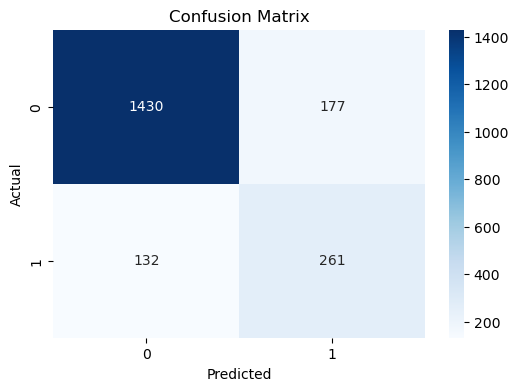

In [16]:
print(classification_report(y_test, X_ts_pred))

# Visualize the mistakes
cm = confusion_matrix(y_test, X_ts_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix')
plt.show()
